In [17]:
! pip install s3fs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 1.9 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 42.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 4.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 2.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 1.7 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.6/301.6 kB 7.0 MB/s eta 0:00:00:00:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.145
    Uninstalling botocore-1.34.145:
      Successfully uninstalled botocore-1.34.145
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.34.145 requires botocore<1.35.0,>=1.34.1

In [1]:
import configparser
import boto3
import pandas as pd
import s3fs

In [2]:
config = configparser.ConfigParser()
config.read('aws.cfg')

aws_access_key = config['AWS']['aws_access_key_id']
aws_secret_key = config['AWS']['aws_secret_access_key']

s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key
)

In [3]:
product = pd.read_csv('s3://techcatalyst-public/resources/sentiment/product.csv')
product.head()

,PRODUCT ID,PRODUCT DESCRIPTION,REVIEW ID
0,1,High-quality smartphone with excellent camera.,R1
1,1,High-quality smartphone with excellent camera.,R2
2,2,Durable laptop with long battery life.,R3
3,2,Durable laptop with long battery life.,R4
4,3,Wireless noise-canceling headphones.,R5


In [4]:
review = pd.read_csv('s3://techcatalyst-public/resources/sentiment/review.csv')
review.head()

,REVIEW ID,REVIEW TEXT
0,R1,"Great camera quality, but battery life could b..."
1,R2,Very satisfied with this smartphone. Worth eve...
2,R3,Excellent performance and battery life. Highly...
3,R4,Disappointed with the build quality. Feels cheap.
4,R5,Fantastic noise cancellation and sound quality.


In [5]:
product_sentiment = product.merge(review, how='inner', on='REVIEW ID')
product_sentiment.head()

,PRODUCT ID,PRODUCT DESCRIPTION,REVIEW ID,REVIEW TEXT
0,1,High-quality smartphone with excellent camera.,R1,"Great camera quality, but battery life could b..."
1,1,High-quality smartphone with excellent camera.,R2,Very satisfied with this smartphone. Worth eve...
2,2,Durable laptop with long battery life.,R3,Excellent performance and battery life. Highly...
3,2,Durable laptop with long battery life.,R4,Disappointed with the build quality. Feels cheap.
4,3,Wireless noise-canceling headphones.,R5,Fantastic noise cancellation and sound quality.


In [6]:
aws_comprehend = boto3.client('comprehend', 'us-west-2',
                aws_access_key_id=aws_access_key,
                aws_secret_access_key=aws_secret_key)

In [8]:
sentiments = []

for text in product_sentiment['REVIEW TEXT']:
    response = aws_comprehend.detect_sentiment(Text=text, LanguageCode='en')
    sentiments.append(response['Sentiment'])

print(sentiments)

['MIXED', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'MIXED', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE']


In [9]:
product_sentiment['SENTIMENT'] = sentiments

product_sentiment.head()

,PRODUCT ID,PRODUCT DESCRIPTION,REVIEW ID,REVIEW TEXT,SENTIMENT
0,1,High-quality smartphone with excellent camera.,R1,"Great camera quality, but battery life could b...",MIXED
1,1,High-quality smartphone with excellent camera.,R2,Very satisfied with this smartphone. Worth eve...,POSITIVE
2,2,Durable laptop with long battery life.,R3,Excellent performance and battery life. Highly...,POSITIVE
3,2,Durable laptop with long battery life.,R4,Disappointed with the build quality. Feels cheap.,NEGATIVE
4,3,Wireless noise-canceling headphones.,R5,Fantastic noise cancellation and sound quality.,POSITIVE


In [10]:
product_sentiment.to_csv('s3://techcatalyst-public/alina/product_sentiment.csv')

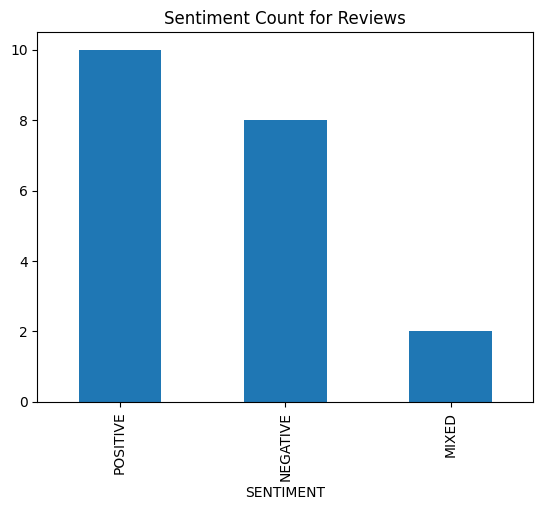

In [32]:
# Import Matplotlib
import matplotlib.pyplot as plt

values = (product_sentiment['SENTIMENT'].value_counts())
sentiment_graph = values.plot(kind='bar', title='Sentiment Count for Reviews')

graph1 = sentiment_graph.get_figure()

graph1.savefig('sentiment_graph.jpeg', format='jpg', bbox_inches = 'tight')

In [36]:
filename = '/workspaces/techcatalyst-de-AB/activities/week6/sentiment_graph.jpeg'
bucket_name = 'techcatalyst-public'  # Replace with your bucket name
key = 'alina/sentiment_graph.jpeg'  # Replace with your file key in S3

# Upload the file to S3
s3.upload_file(Filename = filename, Bucket = bucket_name, Key = key)

In [3]:
rekognition = boto3.client('rekognition', 'us-west-2',
                aws_access_key_id=aws_access_key,
                aws_secret_access_key=aws_secret_key)

In [4]:
states = pd.read_csv('s3://techcatalyst-public/resources/license-plates/states.csv')
states_list = states['0'].to_list()
states_list

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'OH',
 'Ohio',
 'OK',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'TN',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming']

In [5]:
bucket_name = 'techcatalyst-public'
prefix = 'resources/license-plates/'
images = []

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
for obj in response.get('Contents', []):
    if obj['Key'].endswith(('.jpeg', '.png', '.jpg')):
        images.append(obj['Key'])

images

['resources/license-plates/license_plate10.jpeg',
 'resources/license-plates/license_plate11.png',
 'resources/license-plates/license_plate12.jpeg',
 'resources/license-plates/license_plate13.jpeg',
 'resources/license-plates/license_plate3.png',
 'resources/license-plates/license_plate4.jpeg',
 'resources/license-plates/license_plate6.jpeg',
 'resources/license-plates/license_plate7.jpg',
 'resources/license-plates/license_plate8.png',
 'resources/license-plates/license_plate9.jpeg']

In [41]:
detected_text = []
 
for i in images:
    image = {'S3Object': {'Bucket': bucket_name, 'Name': f'{i}'}}
    output = rekognition.detect_text(Image = image)
    detected_text.append(output['TextDetections'][0]['DetectedText'])

detected_text

['ARIZONA',
 'TEXAS',
 'TEXAS',
 'ALABAMA',
 'FEB Massachusetts',
 '- -',
 'AUG',
 'NEVADA',
 'OHIO',
 'ALABAMA']

In [57]:
final = {}

for i in images:
    image = {'S3Object': {'Bucket': bucket_name, 'Name': f'{i}'}}
    output = rekognition.detect_text(Image = image)
    for o in output['TextDetections']:
        if o['Type'] == 'WORD' and o['DetectedText'].upper() in map(str.upper, states_list):
            final[i] = (o['DetectedText'].title())

final

#for d in detected_text:
#    for i in d:
#        texts.append(i['DetectedText'])
                

#texts

{'resources/license-plates/license_plate10.jpeg': 'Arizona',
 'resources/license-plates/license_plate11.png': 'Texas',
 'resources/license-plates/license_plate12.jpeg': 'Texas',
 'resources/license-plates/license_plate13.jpeg': 'Alabama',
 'resources/license-plates/license_plate3.png': 'Massachusetts',
 'resources/license-plates/license_plate4.jpeg': 'Pennsylvania',
 'resources/license-plates/license_plate6.jpeg': 'California',
 'resources/license-plates/license_plate7.jpg': 'Nevada',
 'resources/license-plates/license_plate8.png': 'Ohio',
 'resources/license-plates/license_plate9.jpeg': 'Alabama'}

In [59]:
df = pd.DataFrame(list(final.items()), columns=['Image', 'State'])
df

,Image,State
0,resources/license-plates/license_plate10.jpeg,Arizona
1,resources/license-plates/license_plate11.png,Texas
2,resources/license-plates/license_plate12.jpeg,Texas
3,resources/license-plates/license_plate13.jpeg,Alabama
4,resources/license-plates/license_plate3.png,Massachusetts
5,resources/license-plates/license_plate4.jpeg,Pennsylvania
6,resources/license-plates/license_plate6.jpeg,California
7,resources/license-plates/license_plate7.jpg,Nevada
8,resources/license-plates/license_plate8.png,Ohio
9,resources/license-plates/license_plate9.jpeg,Alabama


In [60]:
df.to_csv('s3://techcatalyst-public/alina/image_state.csv')

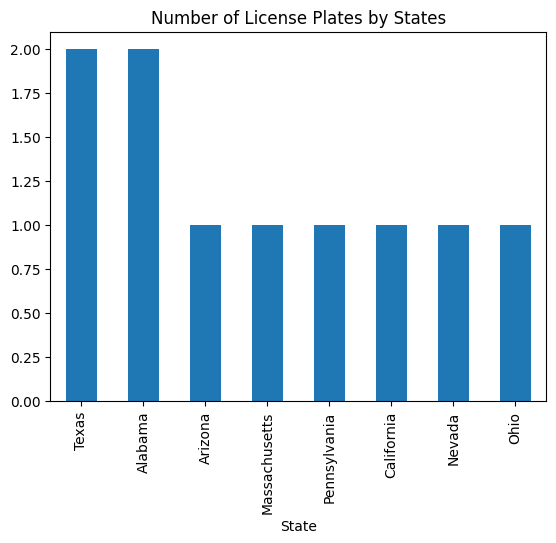

In [62]:
# Import Matplotlib
#import matplotlib.pyplot as plt

values = (df['State'].value_counts())
plates_graph = values.plot(kind='bar', title='Number of License Plates by States')

graph2 = plates_graph.get_figure()

graph2.savefig('plates_graph.jpeg', format='jpg', bbox_inches = 'tight')

In [63]:
filename = '/workspaces/techcatalyst-de-AB/activities/week6/plates_graph.jpeg'
bucket_name = 'techcatalyst-public'  # Replace with your bucket name
key = 'alina/plates_graph.jpeg'  # Replace with your file key in S3

# Upload the file to S3
s3.upload_file(Filename = filename, Bucket = bucket_name, Key = key)